# Library Imports

In [71]:
import pandas as pd
import numpy as np

from functools import reduce

from sqlalchemy import create_engine

from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading

In [72]:
conn = create_engine('sqlite:///data/starbucks_data.db')

offers = pd.read_sql('SELECT * FROM offers', conn)
offers_wo_chnl = offers.drop(columns=['offer_notification_channel']).drop_duplicates()

users = pd.read_sql('SELECT * FROM users', conn)
users['user_age_group'] = users['user_age_group'].fillna('Unknown')
users['user_age_group'] = users['user_age_group'].astype(str)
categories = ['N/A'] + sorted(users['user_age_group'].unique().tolist())[:-1]
users['user_age_group'] = pd.Categorical(users['user_age_group'], categories=categories, ordered=True)

interactions = pd.read_sql('SELECT * FROM interactions', conn)

offer_recv_view_comp = pd.read_sql('offer_recv_view_comp', conn)
offer_recv_view_nocomp = pd.read_sql('offer_recv_view_nocomp', conn)

In [73]:
users

,user_id,user_gender,user_age,user_member_since,user_income,user_tenure,user_age_group,user_income_group
0,68be06ca386d4c31939f3a4f0e3dd783,None,NaN,2017-02-12 00:00:00.000000,NaN,1,N/A,N/A
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15 00:00:00.000000,112000.0,1,55-64,>100k
2,38fe809add3b4fcf9315a9694bb96ff5,None,NaN,2018-07-12 00:00:00.000000,NaN,0,N/A,N/A
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09 00:00:00.000000,100000.0,1,65+,>100k
4,a03223e636434f42ac4c3df47e8bac43,None,NaN,2017-08-04 00:00:00.000000,NaN,1,N/A,N/A
...,...,...,...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,F,45.0,2018-06-04 00:00:00.000000,54000.0,0,45-54,50k-75k
16996,2cb4f97358b841b9a9773a7aa05a9d77,M,61.0,2018-07-13 00:00:00.000000,72000.0,0,55-64,50k-75k
16997,01d26f638c274aa0b965d24cefe3183f,M,49.0,2017-01-26 00:00:00.000000,73000.0,1,45-54,50k-75k
16998,9dc1421481194dcd9400aec7c9ae6366,F,83.0,2016-03-07 00:00:00.000000,50000.0,2,65+,50k-75k


In [74]:
received_offers = interactions[ interactions['intxn_event_type'] == 'offer received' ].copy()
received_offers = received_offers.groupby(['user_id', 'offer_id']).agg({'intxn_event_type': 'count'}).rename(columns={'intxn_event_type': 'received_count'}).reset_index()

received_offers

,user_id,offer_id,received_count
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1
...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1


# Looking into users/offers pairs that were completed

In [75]:
offer_recv_view_comp

,user_id,offer_id,received_event_type,received_time,expiration_time,viewed_event_type,viewed_time,completed_event_type,completed_time
0,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,168,336,offer viewed,186.0,offer completed,252.0
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,408,648,offer viewed,432.0,offer completed,576.0
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,504,672,offer viewed,516.0,offer completed,576.0
3,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,offer received,0,240,offer viewed,12.0,offer completed,54.0
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,408,528,offer viewed,426.0,offer completed,510.0
...,...,...,...,...,...,...,...,...,...
23859,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,offer received,408,528,offer viewed,510.0,offer completed,516.0
23860,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,offer received,0,240,offer viewed,6.0,offer completed,60.0
23861,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,168,408,offer viewed,174.0,offer completed,198.0
23862,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer received,336,504,offer viewed,354.0,offer completed,384.0


In [76]:
# getting information on these completed offers
completed_offers = offer_recv_view_comp[ ['user_id', 'offer_id', 'received_event_type'] ].drop_duplicates().copy()
completed_offers_by_user = completed_offers.groupby(['user_id', 'offer_id']).agg({'received_event_type': 'count'}).rename(columns={'received_event_type': 'completed_count'}).reset_index()

completed_offers_by_user

,user_id,offer_id,completed_count
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1
...,...,...,...
21088,fff7576017104bcc8677a8d63322b5e1,fafdcd668e3743c1bb461111dcafc2a4,1
21089,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1
21090,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
21091,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1


In [77]:
received_v_completed_by_user = pd.merge(received_offers, completed_offers_by_user, how='outer', on=['user_id', 'offer_id'])
received_v_completed_by_user['completed_percent'] = received_v_completed_by_user['completed_count'] / received_v_completed_by_user['received_count']
received_v_completed_by_user = received_v_completed_by_user.fillna(0)

received_v_completed_by_user

,user_id,offer_id,received_count,completed_count,completed_percent
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0.0,0.000000
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0.0,0.000000
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0.0,0.000000
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0.0,0.000000
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0.0,0.000000
...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,1.0,0.500000
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1.0,1.000000
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,1.0,0.333333
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0.0,0.000000


In [78]:
received_v_completed_by_user = pd.merge( received_v_completed_by_user, offers_wo_chnl, how='left', on=['offer_id'] )
received_v_completed_by_user = pd.merge( received_v_completed_by_user, users, how='left', on=['user_id'] )


received_v_completed_by_user = received_v_completed_by_user[ received_v_completed_by_user['offer_type'] != 'informational' ]

received_v_completed_by_user

,user_id,offer_id,received_count,completed_count,completed_percent,offer_type,offer_spend_minimum,offer_reward,offer_duration,user_gender,user_age,user_member_since,user_income,user_tenure,user_age_group,user_income_group
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0.0,0.000000,discount,10,2,168,M,33.0,2017-04-21 00:00:00.000000,72000.0,1,25-34,50k-75k
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0.0,0.000000,bogo,5,5,120,M,33.0,2017-04-21 00:00:00.000000,72000.0,1,25-34,50k-75k
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0.0,0.000000,discount,10,2,240,M,33.0,2017-04-21 00:00:00.000000,72000.0,1,25-34,50k-75k
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,2,0.0,0.000000,bogo,5,5,120,None,NaN,2018-04-25 00:00:00.000000,NaN,0,N/A,N/A
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1.0,1.000000,discount,20,5,240,O,40.0,2018-01-09 00:00:00.000000,57000.0,0,35-44,50k-75k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,1.0,0.500000,bogo,5,5,120,M,34.0,2017-01-23 00:00:00.000000,34000.0,1,25-34,<50k
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1.0,1.000000,discount,20,5,240,F,45.0,2016-11-25 00:00:00.000000,62000.0,2,45-54,50k-75k
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,1.0,0.333333,discount,10,2,168,F,45.0,2016-11-25 00:00:00.000000,62000.0,2,45-54,50k-75k
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0.0,0.000000,bogo,5,5,168,F,45.0,2016-11-25 00:00:00.000000,62000.0,2,45-54,50k-75k


In [124]:
# received_v_completed = received_v_completed_by_user.groupby( ['offer_type', 'offer_spend_minimum', 'offer_reward', 'offer_duration', 'user_gender', 'user_tenure', 'user_age_group', 'user_income_group'], observed=False ).agg({'received_count': 'sum', 'completed_count': 'sum'}).reset_index()
# received_v_completed = received_v_completed_by_user.groupby( ['offer_type', 'offer_spend_minimum', 'offer_reward', 'offer_duration', 'user_gender', 'user_tenure', 'user_age_group', 'user_income_group'], observed=False )[['received_count', 'completed_count']].sum().reset_index()
received_v_completed = received_v_completed_by_user.groupby( ['offer_type', 'user_age_group', 'user_income_group'], observed=False )[['received_count', 'completed_count']].sum().reset_index()
received_v_completed = received_v_completed[ received_v_completed['received_count'] > 0 ]
received_v_completed['completed_perc'] = received_v_completed['completed_count'] / received_v_completed['received_count']

received_v_completed.sort_values( ['received_count', 'completed_count'], ascending=False )

,offer_type,user_age_group,user_income_group,received_count,completed_count,completed_perc
4,bogo,N/A,N/A,3962,290.0,0.073195
39,discount,N/A,N/A,3879,615.0,0.158546
30,bogo,65+,50k-75k,2963,1151.0,0.388458
65,discount,65+,50k-75k,2951,1213.0,0.411047
60,discount,55-64,50k-75k,2478,1095.0,0.441889
25,bogo,55-64,50k-75k,2423,936.0,0.386298
20,bogo,45-54,50k-75k,2357,925.0,0.392448
66,discount,65+,75k-100k,2352,1104.0,0.469388
55,discount,45-54,50k-75k,2334,1019.0,0.436590
31,bogo,65+,75k-100k,2267,1037.0,0.457433


In [125]:
received_v_completed[ received_v_completed['user_age_group'] == 'N/A' ]

,offer_type,user_age_group,user_income_group,received_count,completed_count,completed_perc
4,bogo,N/A,N/A,3962,290.0,0.073195
39,discount,N/A,N/A,3879,615.0,0.158546


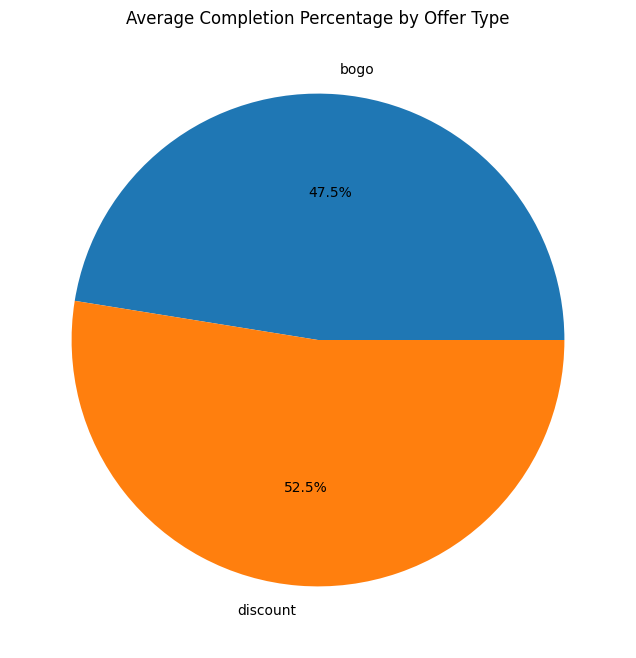

In [121]:
# Aggregate the completed_percent by offer_type for the pie chart
completed_percent_by_offer_type = received_v_completed.groupby('offer_type')['completed_perc'].mean()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    completed_percent_by_offer_type, 
    labels=completed_percent_by_offer_type.index, 
    autopct='%1.1f%%'
)
plt.title('Average Completion Percentage by Offer Type')
plt.show()

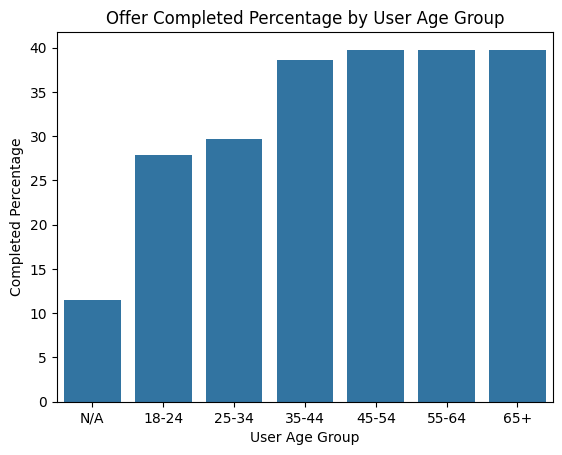

In [138]:
received_v_completed_uag = received_v_completed.groupby(['user_age_group'], observed=False).agg( {'received_count': 'sum', 'completed_count':'sum'} )
received_v_completed_uag['received_perc'] = 100
received_v_completed_uag['completed_perc'] = received_v_completed_uag['completed_count'] / received_v_completed_uag['received_count'] * 100

# bar1 = sns.barplot( data=received_v_completed_uag, x='user_age_group', y='received_perc', errorbar=None, color='white' )
bar2 = sns.barplot( data=received_v_completed_uag, x='user_age_group', y='completed_perc', errorbar=None )

# plt.legend(['Not Completed Percentage', 'Completed Percentage'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel( 'User Age Group' )
plt.ylabel( 'Completed Percentage' )
plt.title('Offer Completed Percentage by User Age Group')
plt.show()

In [110]:
received_v_completed_by_user.groupby( ['user_age_group'], observed=False )[['received_count', 'completed_count']].sum()

,received_count,completed_count
user_age_group,,
N/A,7841,905.0
18-24,3170,885.0
25-34,5006,1486.0
35-44,6705,2591.0
45-54,10696,4249.0
55-64,12432,4944.0
65+,15192,6033.0


In [ ]:
completed_offer_info = pd.merge(completed_offers, offers_wo_chnl, how='left', left_on='offer_id', right_on='offer_id')
completed_offers_v_users = pd.merge(completed_offer_info, users, how='left', on='user_id')
completed_offers_v_users

In [ ]:
completed_offers_by_type_and_user_age = completed_offers_v_users.groupby(['offer_type', 'user_age_group']).agg({'offer_id': 'count'}).rename(columns={'offer_id': 'completed_count'}).reset_index()

completed_offers_by_type_and_user_age

In [ ]:
event_type_by_age_group_chart = sns.catplot(
    data=completed_offers_by_type_and_user_age, kind='bar',
    x='offer_type', y='completed_count', 
    hue='user_age_group', 
    height=5, palette='viridis'
)

event_type_by_age_group_chart.set_axis_labels( 'Event Type', 'Count' )
sns.move_legend(event_type_by_age_group_chart, loc='center right', title='User Age Group')